# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 8 de mayo de 2023__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [51]:
RANDOM_STATE = 1234

# Apartado 1: Análisis de sentimientos


**Número de grupo: 12**

**Nombres de los estudiantes: Greta Angolani y Héloïse Lafargue**

## 1) Carga del conjunto de datos

El fichero `IMBD_Dataset.csv` contiene opiniones de películas clasificadas en 2 categorías diferentes (positiva/negativa).

Este set de datos se creó utilizando el "IMDB Dataset of 50K Movie Reviews", el cual contiene 50,000 reseñas de películas con un sentimiento positivo o negativo adjunto a ellas.

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. Comprueba que la distribución de los ejemplos en las clases es la misma en entrenamiento y test. 

In [52]:
# acceso a google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
import pandas as pd
import numpy as np

In [54]:
imbd_file = '/content/drive/MyDrive/IA2/p3/IMDB_Dataset.csv'
#imbd_file = '/content/drive/MyDrive/UCM/IMDB_Dataset.csv'

df=pd.read_csv(imbd_file)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### a) Ejemplo de cada clase

In [55]:
# Ejemplo de etiqueta positiva
print("Sentiment ", df.sentiment[20])
print("Review: ", df.review[20])
# Ejemplo de etiqueta negativa
print("Sentiment ", df.sentiment[2000])
print("Review: ", df.review[2000])

Sentiment  positive
Review:  After the success of Die Hard and it's sequels it's no surprise really that in the 1990s, a glut of 'Die Hard on a .....' movies cashed in on the wrong guy, wrong place, wrong time concept. That is what they did with Cliffhanger, Die Hard on a mountain just in time to rescue Sly 'Stop or My Mom Will Shoot' Stallone's career.<br /><br />Cliffhanger is one big nit-pickers dream, especially to those who are expert at mountain climbing, base-jumping, aviation, facial expressions, acting skills. All in all it's full of excuses to dismiss the film as one overblown pile of junk. Stallone even managed to get out-acted by a horse! However, if you an forget all the nonsense, it's actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills, and unintentionally, plenty of laughs.<br /><br />You've got to love John Lithgows sneery evilness, his tick every box band of baddies, and best of all, the permanently harassed and hapless 'turncoat

Vemos que hay unos caracteres como "\<br />", las abreviaciones como "s" y "ll" (no el "'t" que es interesante par la negacion) o los numeros que no nos interesan. Asi tendremos que eliminarlos en la normalizacion.

#### b) Estudio del conjunto de datos y normalizacion

Aqui tenemos una descripcion estadistica del conjunto de datos.

In [56]:
# Descripcion del conjunto de datos 
df.describe().transpose()

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,positive,25000


In [57]:
#sentimientos count
df.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Vemos que el conjunto de datos esta balanceado. Esto es importante al momento de aprender bien las dos clases.

Ahora hacemos un estudio del conjunto de datos para ver qué palabras aparecen más veces, y si tendría sentido normalizar de alguna manera el corpus.


In [58]:
from collections import Counter
max_features = 10000
results = Counter()
df['review'].str.split().apply(results.update)
vocabulary = [key[0] for key in results.most_common(max_features)]

print("Las 100 palabras más comunes son:")
top100 = vocabulary[:100]
print(np.transpose(top100))

Las 100 palabras más comunes son:
['the' 'a' 'and' 'of' 'to' 'is' 'in' 'I' 'that' 'this' 'it' '/><br' 'was'
 'as' 'with' 'for' 'The' 'but' 'on' 'movie' 'are' 'film' 'his' 'have'
 'not' 'you' 'be' 'at' 'by' 'he' 'one' 'an' 'from' 'who' 'like' 'all'
 'they' 'has' 'so' 'just' 'or' 'about' 'her' 'out' 'some' 'very' 'more'
 'This' 'would' 'what' 'when' 'good' 'if' 'their' 'only' 'It' 'really'
 'had' 'up' 'even' "it's" 'can' 'which' 'were' 'see' 'my' 'no' 'than'
 'she' '-' 'there' 'been' 'into' 'get' 'will' 'much' 'story' 'because'
 'other' 'most' 'time' 'we' 'me' 'make' 'do' 'how' 'could' 'also' 'people'
 'its' 'great' '/>The' 'first' 'any' "don't" 'made' 'think' 'bad' 'him'
 'being']


In [59]:
from collections import Counter
import nltk
nltk.download("punkt")  # Descargar los recursos necesarios para la tokenización

# Contar la frecuencia de las palabras
word_counts = Counter()
for _, row in df.iterrows():
    tokens = nltk.tokenize.word_tokenize(row["review"])  # Tokenizar las palabras
    word_counts.update(tokens)  # Contar la frecuencia de cada palabra

# Crear un DataFrame con las palabras y sus frecuencias
df_word_counts = pd.DataFrame.from_dict(word_counts, orient="index", columns=["frequency"])
df_word_counts.index.name = "word"
df_word_counts.reset_index(inplace=True)

# Ordenar las palabras por frecuencia
df_word_counts.sort_values(by="frequency", ascending=False, inplace=True)

# Imprimir las 12 palabras más comunes
print("Las 12 palabras más comunes son:")
print(df_word_counts.head(20))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Las 12 palabras más comunes son:
     word  frequency
2     the     573398
22      ,     544030
18      .     467982
44    and     309118
56      a     309103
1      of     285087
68     to     263658
25     is     214740
33      /     202455
34      >     202250
31      <     202094
32     br     201948
50     in     173139
130     I     163294
137    it     151931
7    that     137744
263    's     121768
24   this     120442
41    was      99090
35    The      87819


Seria util eliminar los "\<br />", "'s", "'ll" y los términos con solo una letra, la puntuacion y las palabras cortas muy frecuentes sin relacion a los sentimientos que entonces son demasiado frecuentes para estar criterio de pertenencia a una clase o otra.

En las 100 palabras mas frecuentes :
['the' 'a' 'and' 'of' 'to' 'is' 'in' 'I' 'that' 'this' 'it' '/><br' 'was'
 'as' 'with' 'for' 'The' 'but' 'on' 'movie' 'are' 'film' 'his' 'have'
 'not' 'you' 'be' 'at' 'by' 'he' 'one' 'an' 'from' 'who' 'like' 'all'
 'they' 'has' 'so' 'just' 'or' 'about' 'her' 'out' 'some' 'very' 'more'
 'This' 'would' 'what' 'when' 'good' 'if' 'their' 'only' 'It' 'really'
 'had' 'up' 'even' "it's" 'can' 'which' 'were' 'see' 'my' 'no' 'than'
 'she' '-' 'there' 'been' 'into' 'get' 'will' 'much' 'story' 'because'
 'other' 'most' 'time' 'we' 'me' 'make' 'do' 'how' 'could' 'also' 'people'
 'its' 'great' '/>The' 'first' 'any' "don't" 'made' 'think' 'bad' 'him'
 'being']

 solo conservamos las palabras en relacion con las emociones y sentimientos: 'like', 'very', 'more', 'good', 'really','much', 'most', 'great', 'first', 'don't', 'bad'.

Entonces ahora hacemos la normalizacion, asi seria mas facil trabajar con el corpus.

Por eso, realizamos un preprocesamiento simple con la librería nltk que consiste en eliminar estos caracteres especiales y eliminar palabras vacías. No tenemos que pasar a minúsculas porque el CountVectorizer lo hace automaticamente.

In [60]:
import nltk
import re

wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
#stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    doc = doc.lower()
    doc = re.sub('<br />', ' ', doc) # removing "<br />"
    doc = re.sub(r'\b(\'s|\'ll)', ' ', doc) # removing abreviations
    doc = re.sub(r'\b(the|and|of|to|is|in|i|that|this|it|was|as|with|for|but|on|movie|are|film|his|have|not|you|be|at|by|he)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'\b(one|an|from|who|all|they|has|so|just|or|about|her|out|some|this|would|what|when|if|their|only)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'\b(had|up|even|can|which|were|see|my|no|than|she|there|been|into|get|will|story)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'\b(because|other|time|we|me|make|do|how|could|also|people|its|first|any|made|think|him|being)\b', ' ', doc) # removing the useless words
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A) # removing all non-letter characters (excluding spaces)
    doc = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc) # remove all single characters
    doc = re.sub(r'\s+', ' ', doc, flags=re.I) # substituting multiple spaces with single space
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens] #if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
norm_corpus = normalize_corpus(df.review)
norm_corpus

array(['reviewers mentioned after watching oz episode hooked right exactly happened thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison where cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish more scuffles death stares dodgy dealings shady agreements never far away say main appeal show due fact goes where shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around episode ever saw struck nasty surreal couldnt say ready watched more developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order away well mannered middle class inmates turned prison

#### c) Partición de los datos (80-20)

Creamos una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función train_test_split de sklearn. 

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(norm_corpus, df.sentiment,test_size=0.20, random_state=1, stratify=df.sentiment)

In [63]:
print("Training texts:", len(X_train))
print("Test texts:", len(X_test))
print("Sentimiento: \n", y_train)

Training texts: 40000
Test texts: 10000
Sentimiento: 
 20429    negative
16772    positive
30332    negative
972      positive
39991    positive
           ...   
11545    negative
41398    positive
37596    negative
36958    negative
19759    negative
Name: sentiment, Length: 40000, dtype: object


Y comprobamos que la distribución de los ejemplos en las clases es la misma en entrenamiento y test. 

In [64]:
# Distribuciones de las clases en entrenamiento y test
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)

print("Distribución de etiquetas en el conjunto de entrenamiento:")
print(train_distribution)
print()
print("Distribución de etiquetas en el conjunto de test:")
print(test_distribution)

Distribución de etiquetas en el conjunto de entrenamiento:
negative    0.5
positive    0.5
Name: sentiment, dtype: float64

Distribución de etiquetas en el conjunto de test:
negative    0.5
positive    0.5
Name: sentiment, dtype: float64


## 2) Estudio del efecto de distintas representaciones y distintos algoritmos para resolver la tarea

Construye distintas representaciones vectoriales basadas en lo contado en las clases de teoría (bolsas de palabras con 2 configuraciones distintas significativas) y utilízalas con 2 de los algoritmos estudiados (árboles de decisión y naive bayes)

Para una única configuración, muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?


#### a) Bolsas de palabras

TF-IDF: Peso asociado a cada término en el documento

##### 1) Configuracion 1°: Representación basada en bolsa de palabras y frecuencia de aparición

Obteniendo la frecuencia de los términos de los documentos con un diccionario inferido del conjunto de entrenamiento.

En primer lugar vamos a generar la bolsa de palabras con TF-IDF.

El primer paso es obtener las frecuencias de las palabras con CountVectorizar y lo haremos usando el diccionario que se inferirá de los términos de los documentos que se le pasan al CountVectorizer. También queremos usar la lista de palabras que proporciona sklearn para el inglés (parámetro stop_words con el valor english).


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer1 = CountVectorizer(stop_words = 'english') #, max_df = 0.001)
# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data_1=vectorizer1.fit_transform(X_train)

Vamos a ver cómo han quedado los términos con los parámetros por defecto y cuántos términos hay.

In [78]:
feature_names1 = vectorizer1.get_feature_names_out()
print(len(feature_names1))

120671


In [79]:
print(feature_names1[:100])
print(feature_names1[-100:])

['02' '10' '1942' '1992' '1997' '2006' '2040' '20th' '26' '7th' '911' '98'
 'aa' 'aaa' 'aaaaaaaaaaaahhhhhhhhhhhhhh' 'aaaaaaaargh' 'aaaaaaah'
 'aaaaaaahhhhhhggg' 'aaaaagh' 'aaaaah' 'aaaaahhhh' 'aaaaargh' 'aaaahhhhhh'
 'aaaahhhhhhh' 'aaaand' 'aaaarrgh' 'aaaawwwwww' 'aaagh' 'aaah'
 'aaahhhhhhh' 'aaall' 'aaand' 'aaargh' 'aaarrrgh' 'aaaugh' 'aab' 'aachen'
 'aada' 'aadha' 'aag' 'aage' 'aaghh' 'aah' 'aahed' 'aahhh' 'aahhhh'
 'aahing' 'aailiyah' 'aaip' 'aaja' 'aajala' 'aak' 'aakash' 'aaker'
 'aakrosh' 'aalcc' 'aaliyah' 'aames' 'aamilne' 'aamir' 'aamr' 'aan'
 'aankh' 'aankhen' 'aaoon' 'aapke' 'aapkey' 'aaran' 'aardman' 'aardvarks'
 'aarf' 'aargh' 'aarghlet' 'aarika' 'aaron' 'aaronjd' 'aarp' 'aarrrgh'
 'aashok' 'aasman' 'aatish' 'aaton' 'aau' 'aauugghh' 'aavjo' 'aawip'
 'aaww' 'ab' 'ababyhavingseriousissues' 'aback'
 'abadchildhoodobsessivelystalksmarriedman' 'abagail' 'abahy' 'abanazer'
 'abandon' 'abandoned' 'abandoning' 'abandonment' 'abandons' 'abanks']
['zoomed' 'zooming' 'zoomins' 'zooms' 

Vamos a ver los términos extraídos para los mensajes de antes.

In [ ]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [80]:
#write_terms(feature_names, train_data.data, train_vector_data, 10)
write_terms(feature_names1, None, train_vector_data_1, 20)

write_terms(feature_names1, None, train_vector_data_1, 2000)

Mensaje 20 vectorizado: ['abound' 'acting' 'actor' 'actors' 'actually' 'american' 'amused' 'angst'
 'art' 'attack' 'bears' 'beautiful' 'beautifully' 'braga' 'brazil'
 'businessman' 'cameos' 'captors' 'community' 'craft' 'davis' 'dictator'
 'dies' 'dishing' 'doesnt' 'doing' 'dreyfuss' 'drink' 'dumb' 'exceptional'
 'existential' 'fall' 'food' 'forced' 'fun' 'gets' 'girlfriend' 'going'
 'good' 'great' 'guard' 'ham' 'hard' 'having' 'head' 'heart' 'hilt'
 'household' 'humorous' 'jonathan' 'jr' 'julia' 'kidnapped' 'laughs'
 'leads' 'lifetime' 'light' 'like' 'little' 'location' 'locations'
 'looking' 'lot' 'lots' 'love' 'makes' 'members' 'mercilessly' 'neonazi'
 'palace' 'particularly' 'play' 'playacting' 'plays' 'raul' 'resemblance'
 'richard' 'sammy' 'script' 'secret' 'semiretired' 'seriously' 'service'
 'shtick' 'skewers' 'sonia' 'staff' 'supporting' 'tables' 'theater'
 'thing' 'treat' 'turns' 'unknown' 'usual' 'versa' 'vice' 'winters' 'work'
 'works'] 

Mensaje 2000 vectorizado: ['aboard'

Observamos que no hay ruido gracias a la normalizacion que hemos hecho antes.

In [ ]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data_1 = vectorizer1.transform(X_test)

##### 2) Configuracion 2°: Representación basada en bolsa de palabras y TF-IDF

Obteniendo la frecuencia de los términos de los documentos con un diccionario elaborado previamente

En este segundo intento vamos a usar un diccionario (https://github.com/dwyl/english-words/blob/master/words.txt). 

Al usar el diccionario sucede lo siguiente:

- Los términos serán únicamente los presentes en el diccionario por lo que tenemos más control sobre ellos
- El diccionario no incluirá términos que pueden aparecer en el texto, y esto puede quitar ruido, pero elimina jerga específica que no figura en el diccionario.

El diccionario será una lista de términos que se le pasará al CountVectorizer a través del parámetro vocabulary. En este caso volveremos a usar la lista de palabras vacías que proporciona sklearn para el inglés (parámetro stop_words=english).

Como queremos usar TF-IDF una vez obtenida la frecuencia de los términos para este nuevo diccionario, vamos a usar TfidfTransformer para matizarla según lo frecuente que sea ese término en el conjunto de textos de entremiento.

El primer paso es configurar el nuevo CountVectorizer con el diccionario del archivo words.txt.


In [ ]:
# acceso a google drive

from google.colab import drive
drive.mount('/content/drive')

# Pasamos el fichero a una lista (una línea por item)
with open('/content/drive/MyDrive/IA2/p3/words.txt') as f:
    dictionary = f.read().splitlines()

# El diccionario cargado lo pasamos en el parámetro vocabulary    
vectorizer2 = CountVectorizer(vocabulary=dictionary, stop_words='english')   

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vamos a ver cuántos términos hay en el diccionario.


In [81]:
feature_names2 = vectorizer2.get_feature_names_out()
print(len(feature_names2))

466551


Hay muchos más términos en un diccionario de propósito general que en uno inferido de un corpus de textos sobre un pequeño subconjunto de temas.
En nuestro corpus tenemos 120671 términos mientras hay 466551 en el diccionario.

In [ ]:
train_vector_data_2 = vectorizer2.fit_transform(X_train)
#print(train_vector_data[10])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

# Calculamos el valor TF-IDF 

tfidfer = TfidfTransformer()
train_preprocessed_2 = tfidfer.fit_transform(train_vector_data_2)
#print(train_preprocessed[10])

In [ ]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data_2=vectorizer2.transform(X_test)
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed_2=tfidfer.transform(test_vector_data_2)

Para esta configuración, vamos a mostrar algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

In [82]:
# Ejemplo de etiqueta positiva
write_terms(feature_names2, df.review, train_vector_data_2, 20)

# Ejemplo de etiqueta negativa
write_terms(feature_names2, df.review, train_vector_data_2, 2000)

Mensaje 20 : After the success of Die Hard and it's sequels it's no surprise really that in the 1990s, a glut of 'Die Hard on a .....' movies cashed in on the wrong guy, wrong place, wrong time concept. That is what they did with Cliffhanger, Die Hard on a mountain just in time to rescue Sly 'Stop or My Mom Will Shoot' Stallone's career.<br /><br />Cliffhanger is one big nit-pickers dream, especially to those who are expert at mountain climbing, base-jumping, aviation, facial expressions, acting skills. All in all it's full of excuses to dismiss the film as one overblown pile of junk. Stallone even managed to get out-acted by a horse! However, if you an forget all the nonsense, it's actually a very lovable and undeniably entertaining romp that delivers as plenty of thrills, and unintentionally, plenty of laughs.<br /><br />You've got to love John Lithgows sneery evilness, his tick every box band of baddies, and best of all, the permanently harassed and hapless 'turncoat' agent, Rex Lin

Se han eliminado todos los articulos, los pronombres y la mayoría de palabras genéricas que no son específicas "positivo" o "negativo" en concreto y quedan las palabras más específicas para determinar el sentimiento como "amused", "beautifull", "beautifully" o "horrified", "villain"...

### Entrenando los modelos de aprendizaje automático

Vamos a probar los clasificadores que ya conocemos en el problema de clasificación de textos.

La versión que vamos a usar de los clasificadores es la versión por defecto. Sin embargo, es posible encontrar mejores clasificadores buscando combinaciones de parámetros más adecuadas durante el aprendizaje. 

#### Árbol de decisión 

In [ ]:
from sklearn import tree
import numpy as np

# Configuracion 1
print("Con la configuracion 1 ________________________________________")
# Creamos el clasificador con los valores por defecto
tree_classifier_1 = tree.DecisionTreeClassifier()
tree_classifier_1.fit(train_vector_data_1, y_train)

tree_train_predictions_1 = tree_classifier_1.predict(train_vector_data_1)
tree_test_predictions_1 = tree_classifier_1.predict(test_vector_data_1)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions_1 == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions_1 == y_test))

# Configuracion 2
print("Con la configuracion 2 ________________________________________")
# Creamos el clasificador con los valores por defecto
tree_classifier_2 = tree.DecisionTreeClassifier()
tree_classifier_2.fit(train_preprocessed_2, y_train)

tree_train_predictions_2 = tree_classifier_2.predict(train_preprocessed_2)
tree_test_predictions_2 = tree_classifier_2.predict(test_preprocessed_2)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions_2 == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions_2 == y_test))

Con la configuracion 1 ________________________________________
Árbol, porcentaje de aciertos en entrenamiento: 1.0
Árbol, porcentaje de aciertos en test: 0.7351
Con la configuracion 2 ________________________________________
Árbol, porcentaje de aciertos en entrenamiento: 1.0
Árbol, porcentaje de aciertos en test: 0.7198


Hay un pequeno sobre-aprendizaje, por lo que seria conveniente mejorar el árbol modificando los parámetros de entrenamiento para que aumente la capacidad de generalización del árbol.

En el caso de los árboles de decisión podemos obtener las variables con mayor poder de discriminación en el árbol obtenido, es decir, aquellas que mayor reducción de Gini han producido a lo largo del árbol.

In [83]:
def print_top20_features_in_trees(vectorizer, clf):
    """Prints features with the highest coefficient values"""
    feature_names = vectorizer.get_feature_names_out()
    
    top20 = np.argsort(clf.feature_importances_)[-20:]
    reversed_top = top20[::-1]
    print("Top 20 features in the tree\n")
    print("%s" % ( " / ".join(feature_names[j] for j in reversed_top)))

In [84]:
# Configuracion 1
print("Con la configuracion 1:")
print_top20_features_in_trees(vectorizer1,tree_classifier_1)
# Configuracion 2
print("Con la configuracion 2:")
print_top20_features_in_trees(vectorizer2,tree_classifier_2)

Con la configuracion 1:
Top 20 features in the tree

bad / worst / great / waste / awful / boring / excellent / best / stupid / poor / terrible / wonderful / minutes / love / life / poorly / dull / wasted / supposed / plot
Con la configuracion 2:
Top 20 features in the tree

bad / worst / waste / awful / excellent / stupid / wonderful / poor / terrible / minutes / supposed / dull / poorly / amazing / favorite / plot / instead / fails / enjoyed / lame


Aqui es muy claro que estamos encontrando palabras que remiten a los sentimientos negativos o positivos para los nodos de decision en el arbol.

El arbol toma variables de separacion que parecen muy pertinentes para el problema.

#### Naive Bayes

El clasificador [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) es un clasificador probabilístico muy simple y muy poderoso en este (y otros) contextos. 

El clasificador aprende cómo de frecuente es cada clase y cómo de frecuente es que una palabra ocurra en cada clase. A la hora de clasificar un texto nuevo, el clasificador estima la probabilidad de que pertenezca a cada una de las clases y elige la más alta. 
Los clasificadores Naive Bayes Classifiers se entrenan muy rápido, pero no son los mejores. Suelen ser utilizados como clasificadores de referencia.


Vamos a trabajar con el **Naive Bayes Multinomial**.

__Naive Bayes Multinomial__ se utiliza cuando las variables son enteras (como el número de apariciones de cada palabra en el documento) pero también se "traga" datos con decimales (como el valor TF/IDF). No admite números negativos.

En el caso del análisis de sentimiento de un texto, lo importante puede ser la presencia o ausencia de palabras que indiquen un sentimiento positivo o negativo, y no tanto su frecuencia. En estos casos se puede utilizar una versión binarizada del Naive Bayes Multinomial basada en la representación binarizada de los vectores bolsa de palabras (CountVectorizer con el parámetro binary=True).

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Configuracion 1
print("Con la configuracion 1 ________________________________________")
mnb_classifier_1 = MultinomialNB()
mnb_classifier_1.fit(train_vector_data_1, y_train)

mnb_train_predictions_1 = mnb_classifier_1.predict(train_vector_data_1)
mnb_test_predictions_1 = mnb_classifier_1.predict(test_vector_data_1)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions_1 == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions_1 == y_test))

# Configuracion 2
print("Con la configuracion 2 ________________________________________")
mnb_classifier_2 = MultinomialNB()
mnb_classifier_2.fit(train_preprocessed_2, y_train)

mnb_train_predictions_2 = mnb_classifier_2.predict(train_preprocessed_2)
mnb_test_predictions_2 = mnb_classifier_2.predict(test_preprocessed_2)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions_2 == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions_2 == y_test))

Con la configuracion 1 ________________________________________
Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.912225
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8639
Con la configuracion 2 ________________________________________
Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.8967
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8623


El clasificador de Naive Bayes funciona muy bien, y en la configuracion hay un ligero sobre-aprandizaje mientras que con TF-IDF, el porcentaje de adciertos es muy bueno y no hay sobre o sub-aprendizaje.

En el caso del Naive Bayes, por cada una de las clases a predecir, podemos obtener aquellas palabras que es más verosímil que aparezcan. 

In [ ]:
def print_top20_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.feature_log_prob_[i])[-20:]
        reversed_top = top20[::-1]
        
        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')
        
        #Descomentar para ver el índice de los términos en el diccionario
        #print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

In [ ]:
# Configuracion 1
print("Con la configuracion 1:")
print_top20_features_per_class_in_NB(vectorizer1,mnb_classifier_1,['negative','positive'])       
# Configuracion 2
print("Con la configuracion 2:")
print_top20_features_per_class_in_NB(vectorizer2,mnb_classifier_2,['negative','positive'])       

Con la configuracion 1:
Top 20 features per class

negative: like / bad / good / really / dont / movies / plot / acting / way / characters / watch / character / did / know / better / seen / films / little / say / thing 

positive: like / good / great / really / love / best / life / way / films / characters / character / movies / dont / seen / watch / man / little / does / know / did 

Con la configuracion 2:
Top 20 features per class

negative: bad / like / really / dont / acting / movies / plot / watch / worst / better / characters / way / watching / know / character / thing / didnt / films / actors / funny 

positive: like / really / movies / watch / films / way / characters / dont / character / know / years / funny / does / end / excellent / real / series / acting / cast / makes 



Con este resultado vemos que encontramos bien palabras despectivas para la clase "negativo" (bad, dont, worst) y palabras meliorativas para la clase "positivo" (like, funny, excellent). Pero hay muchas variables comunes a los dos campos, entonces no son utiles para determinar el sentimiento.

## 3) Análisis comparativo final

Se han entrenado varios clasificadores usando vectorizaciones diferentes de los datos. Compara las diferencias entre representaciones para un mismo algoritmo y entre algoritmos. Explica a qué crees que se deben las diferencias.

Analiza con detalle el mejor clasificador de cada tipo. Indica las palabras más relevantes. Busca un ejemplo mal clasificado de cada clase, justifica el error ¿se te ocurre alguna forma de solucionarlo?


### Evaluación detallada del mejor clasificador para las dos configuraciones

Para los dos algoritmos vamos a comparar la eficencia que cada clasificador.

Configuracion 1 y arbol de decision ___________________________________


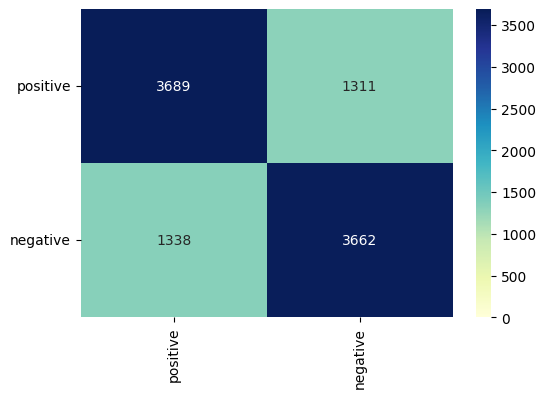

Configuracion 1 y Naive Bayes _________________________________________


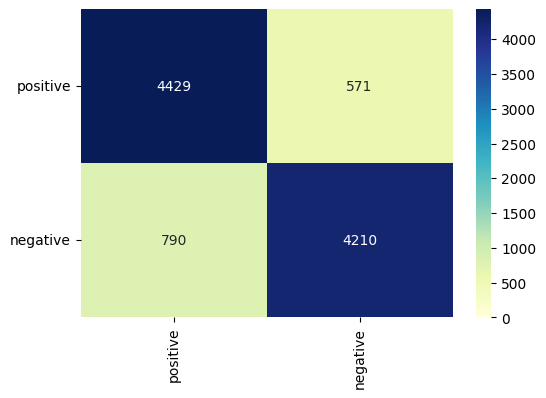

In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["positive", "negative"];

# Configuracion 1 y arbol de decision
print("Configuracion 1 y arbol de decision ___________________________________")
conf_matrix = confusion_matrix(y_test, tree_test_predictions_1)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

# Configuracion 2 y Naive Bayes
print("Configuracion 1 y Naive Bayes _________________________________________")
conf_matrix = confusion_matrix(y_test, mnb_test_predictions_1)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Para la 1era configuracion con bolsa de palabras, Naives Bayes funciona mucho mejor que el arbol de decision ya que se equivoca mas el arbol (1323 y 1310 errores, mientras NB 790 y 571). 

Configuracion 2 y arbol de decision ___________________________________


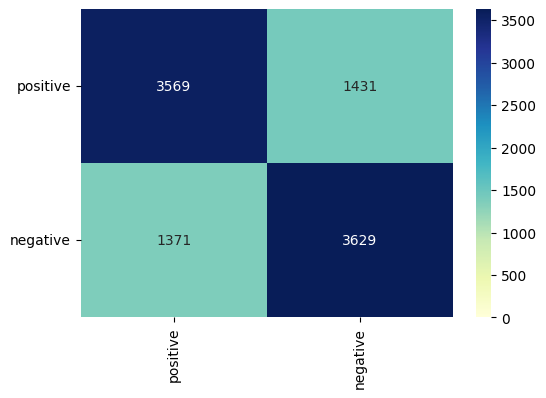

Configuracion 2 y Naive Bayes _________________________________________


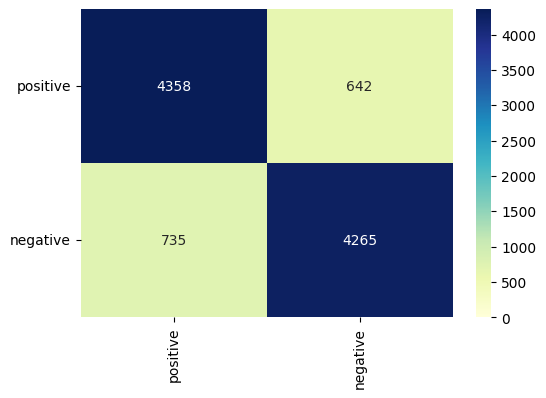

In [ ]:
# Configuracion 2 y arbol de decision
print("Configuracion 2 y arbol de decision ___________________________________")
conf_matrix = confusion_matrix(y_test, tree_test_predictions_2)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

# Configuracion 2 y Naive Bayes
print("Configuracion 2 y Naive Bayes _________________________________________")
conf_matrix = confusion_matrix(y_test, mnb_test_predictions_2)
conf_matrix_df = pd.DataFrame(conf_matrix, index=target_names, columns=target_names)

plt.figure(figsize=(6, 4))
sn.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

Para la 2nda configuracion con bolsa de palabras, Naives Bayes funciona mucho mejor que el arbol de decision ya que se equivoca mas el arbol (1359 y 1391 errores, mientras NB 735 y 642). 

Naives Bayes

In [65]:
from sklearn.metrics import classification_report, confusion_matrix

classifier= mnb_classifier_1
predictions = mnb_test_predictions_1

print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.85      0.89      0.87      5000
    negative       0.88      0.84      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [66]:
classifier= mnb_classifier_2
predictions = mnb_test_predictions_2

print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.86      0.87      0.86      5000
    negative       0.87      0.85      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



Para las dos configuraciones, los resultados de accuracy, recall y f1-score son muy buenos con Naive-Bayes.

Árboles de decisión

In [67]:
classifier= tree_classifier_1
predictions = tree_test_predictions_1

print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.73      0.74      0.74      5000
    negative       0.74      0.73      0.73      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



In [68]:
classifier= tree_classifier_2
predictions = tree_test_predictions_2

print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

    positive       0.72      0.71      0.72      5000
    negative       0.72      0.73      0.72      5000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



Con el arbol de decision, los resultados son un poco menos interesantes.

Entonces tanto para la configuracion 1 que la 2 con TF-IDF, Naive Bayes funciona mejor. El clasificador NB simplifica la realidad asumiendo que
todas las variables utilizadas para clasificar son independientes.

### Analisis del mejor clasificador : Naive Bayes

La palabras mas relevantes en cada clase son las siguientes :

In [69]:
# Configuracion 1
print("Con la configuracion 1 ____________________________________")
print_top20_features_per_class_in_NB(vectorizer1,mnb_classifier_1,['negative','positive'])       
# Configuracion 2
print("Con la configuracion 2 ____________________________________")
print_top20_features_per_class_in_NB(vectorizer2,mnb_classifier_2,['negative','positive'])       

Con la configuracion 1 ____________________________________
Top 20 features per class

negative: like / bad / good / really / dont / movies / plot / acting / way / characters / watch / character / did / know / better / seen / films / little / say / thing 

positive: like / good / great / really / love / best / life / way / films / characters / character / movies / dont / seen / watch / man / little / does / know / did 

Con la configuracion 2 ____________________________________
Top 20 features per class

negative: bad / like / really / dont / acting / movies / plot / watch / worst / better / characters / way / watching / know / character / thing / didnt / films / actors / funny 

positive: like / really / movies / watch / films / way / characters / dont / character / know / years / funny / does / end / excellent / real / series / acting / cast / makes 



Ahora vamos a buscar un ejemplo mal clasificado de cada clase.


Primero vamos a ver un ejemplo que hubiera tenido que ser positivo y fue predictado como negativo.

In [70]:
y = y_test.tolist()

In [87]:
i = 0
for i in range (len(mnb_test_predictions_1)):
  if (y[i] == 'positive'):
    if(mnb_test_predictions_1[i] != y[i]):
        print("True sentiment:", y[i], ", Prediction:",mnb_test_predictions_1[i],", message n°", i, "\n")
        break
write_terms(feature_names1, X_test.tolist(), test_vector_data_1, 7)

True sentiment: positive , Prediction: negative , message n° 7 

Mensaje 7 : incredible melting man fantastically gross trashy energetic zgrade production every selfrespecting camphorror freak simply herself ideal way describe lowbudget gem like shameless copy hammer quatermass xperiment thousand times filthier astronaust steve west survivor disastrous spacemission turns carrier horrible disease makes radioactive causes melt shock after seeing face mirror blame steve busts hospital leaving trail sticky pus fallen off body parts behind doctor ted nelson find urgently disease set steve insatiable appetite human flesh premise may sound utterly stupid flick enormously entertaining contains great effects hand rick baker melting dude face looks like rotting pizza heavy breathing makes sound like darth vader another big advantage william sachs screenplay doesnt waste tedious scientific explanations emotional speeches repulsiveness starts right away lasts until very last moment enjoy silly hor

El error en la predicción del sentimiento del mensaje n° 7 puede deberse a la presencia de términos con connotaciones negativas como "disastrous", "repulsiveness", "tedious" y "stupidities", aunque en general, el mensaje parece tener una connotación positiva hacia el género de cine de terror.

Una forma de solucionar este error sería entrenar el modelo con un conjunto de datos más equilibrado y representativo de las diferentes formas en que las personas utilizan el lenguaje para expresar sentimientos. Además, se podría utilizar técnicas de análisis semántico y contextual para capturar mejor el significado y la intención detrás del mensaje.

Segundo vamos a ver un ejemplo que hubiera tenido que ser negativo y fue predictado como positivo.

In [88]:
i = 0
for i in range (len(mnb_test_predictions_2)):
    if (y[i] == 'negative'):
      if(mnb_test_predictions_2[i] != y[i]):
          print("True sentiment:", y[i], ", Prediction:",mnb_test_predictions_2[i],", message n°", i, "\n")
          break
write_terms(feature_names2, X_test.tolist(), test_vector_data_2, 14)

True sentiment: negative , Prediction: positive , message n° 14 

Mensaje 14 : probably entry lance olearynurse keat detective series subsequent oleary films played much younger actors guy kibbee group relatives played wellknown character actors gathers old house rainy nite course speak wealthy relative goes coma while wait recover sorts mysterious goings happen including couple murders creepy worth seeing
Mensaje 14 vectorizado: ['actors' 'character' 'coma' 'couple' 'course' 'creepy' 'detective'
 'entry' 'films' 'goings' 'group' 'happen' 'including' 'keat' 'mysterious'
 'murders' 'oleary' 'played' 'probably' 'rainy' 'recover' 'relative'
 'relatives' 'seeing' 'series' 'sorts' 'speak' 'subsequent' 'wellknown'] 



El mensaje 14 fue mal clasificado como positivo, cuando en realidad es negativo. El texto describe una trama de misterio y asesinatos en una casa vieja y aterradora. El error en la predicción del sentimiento se debe a que el modelo no está teniendo en cuenta el contexto general del mensaje y está centrado en algunas palabras aisladas, como "well-known", "worth seeing" y "subsequent", que pueden sugerir una connotación positiva. Aunque el mensaje menciona que vale la pena verla, esto no indica una connotación positiva, ya que muchas películas de terror o de misterio son consideradas "buenas" debido a su capacidad para asustar o mantener al espectador en tensión.

Una posible forma de solucionar este error de clasificación es mejorar el modelo de clasificación utilizando un conjunto de datos más grande y diverso. También se puede considerar agregar características adicionales a la vectorización de los mensajes, como la presencia de palabras clave específicas para diferentes emociones. Además, se podría entrenar el modelo con técnicas de aprendizaje semi-supervisado, utilizando etiquetas adicionales de mensajes para mejorar la precisión de la clasificación.Otra opción es utilizar un modelo de aprendizaje profundo que tenga en cuenta el contexto general del mensaje.